In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [ ]:
sdir = '/content/drive/MyDrive/XrayKneeOsteoarthritis'
image_size = (224, 224)
batch_size = 32
k_folds = 5

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
1  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
2  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
3  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
4  /content/drive/MyDrive/XrayKneeOsteoarthritis/...      0
labels
0    3798
2    2545
4    1790
1    1749
3    1281
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

print(train_df['labels'].value_counts())
print(test_df['labels'].value_counts())

labels
0    3038
2    2036
4    1432
1    1399
3    1025
Name: count, dtype: int64
labels
0    760
2    509
4    358
1    350
3    256
Name: count, dtype: int64


In [ ]:
datagen = ImageDataGenerator(
  rescale=1.0/255,
  horizontal_flip = True,
  )

valid_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_gen = test_generator.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=image_size,
    batch_size=batch_size, class_mode='categorical', shuffle = True
)

print("Preprocessing dataset selesai.")

Found 2233 validated image filenames belonging to 5 classes.
Preprocessing dataset selesai.


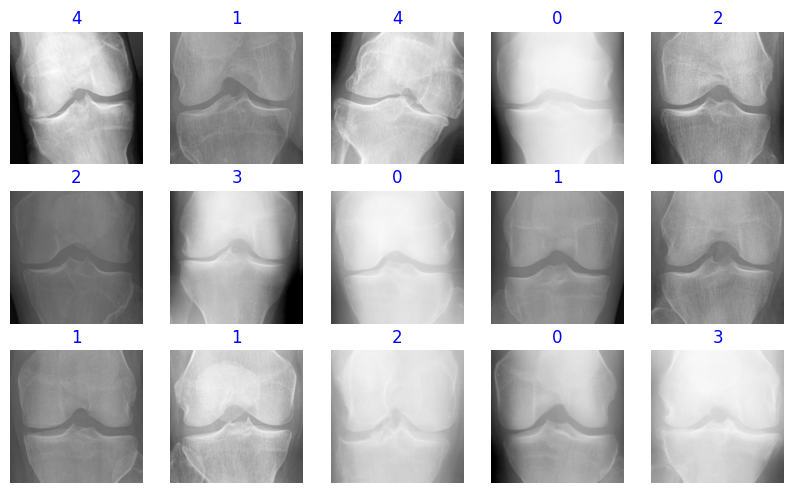

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(10, 10))
    length=len(labels)
    if length<15:   #show maximum of 25 images
        r=length
    else:
        r=15
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(test_gen)

In [ ]:
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

def create_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer kecuali 4 terakhir
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    x = base_model.output

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

fold_accuracies = []
histories = []
fold = 1

for train_index, val_index in kf.split(train_df, train_df['labels']):
    print(f'\nTraining Fold {fold}...')

    fold_train_df = train_df.iloc[train_index].reset_index(drop = True)
    fold_valid_df = train_df.iloc[val_index].reset_index(drop = True)

    classes = np.unique(fold_train_df['labels'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=fold_train_df['labels'])
    class_weight_dict = dict(zip(classes, class_weights))
    print(f"Class weights (Fold {fold}):", class_weight_dict)

    train_gen = datagen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = valid_generator.flow_from_dataframe(
        fold_valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold} - Loss: {scores[0]} - Accuracy: {scores[1]*100:.2f}%")

    fold_accuracies.append(scores[1] * 100)
    fold += 1

print('=================================')
print(f'Average accuracy over {k_folds} folds: {np.mean(fold_accuracies):.2f}% (+/- {np.std(fold_accuracies):.2f})')
print('=================================')



Training Fold 1...
Class weights (Fold 1): {'0': np.float64(0.5879835390946502), '1': np.float64(1.2768543342269885), '2': np.float64(0.8771025168815224), '3': np.float64(1.742439024390244), '4': np.float64(1.2467713787085515)}
Found 7144 validated image filenames belonging to 5 classes.
Found 1786 validated image filenames belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2966s 13s/step - accuracy: 0.3380 - loss: 1.5562 - val_accuracy: 0.4239 - val_loss: 1.1904 - learning_rate: 1.0000e-04
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 304ms/step - accuracy: 0.5409 - loss: 1.0720 - val_accuracy: 0.4810 - val_loss: 1.2769 - learning_rate: 1.0000e-04
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 93s 352ms/step - accuracy: 0.6170 - loss: 0.9229 - val_accuracy: 0.1904 - val_loss: 2.4578 - learning_rate: 1.0000e-04
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 71s 301ms/step - accuracy: 0.6464 - loss: 0.8432 - val_accuracy: 0.6411 - val_loss: 0.8449 - learning_rate: 2.0000e-05
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 303ms/step - accuracy: 0.6782 - loss: 0.7697 - val_accuracy: 0.6904 - val_loss: 0.7495 - learning_rate: 2.0000e-05
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.6988 - loss: 0.7469 - val_accuracy: 0.6915 - val_loss: 0.7438 - learning_rate: 2.0000e-05
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 30

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.3484 - loss: 1.5570 - val_accuracy: 0.2783 - val_loss: 1.6820 - learning_rate: 1.0000e-04
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 302ms/step - accuracy: 0.5308 - loss: 1.0822 - val_accuracy: 0.5845 - val_loss: 1.0447 - learning_rate: 1.0000e-04
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 303ms/step - accuracy: 0.5979 - loss: 0.9485 - val_accuracy: 0.5050 - val_loss: 1.4985 - learning_rate: 1.0000e-04
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 301ms/step - accuracy: 0.6396 - loss: 0.8641 - val_accuracy: 0.2665 - val_loss: 2.5605 - learning_rate: 1.0000e-04
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.6764 - loss: 0.7735 - val_accuracy: 0.7100 - val_loss: 0.7098 - learning_rate: 2.0000e-05
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.6939 - loss: 0.7372 - val_accuracy: 0.6853 - val_loss: 0.7721 - learning_rate: 2.0000e-05
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 30

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 80s 321ms/step - accuracy: 0.3471 - loss: 1.5126 - val_accuracy: 0.4966 - val_loss: 1.0930 - learning_rate: 1.0000e-04
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.5443 - loss: 1.0611 - val_accuracy: 0.6075 - val_loss: 0.9336 - learning_rate: 1.0000e-04
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.6080 - loss: 0.9535 - val_accuracy: 0.6680 - val_loss: 0.8111 - learning_rate: 1.0000e-04
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.6573 - loss: 0.8377 - val_accuracy: 0.6086 - val_loss: 0.9159 - learning_rate: 1.0000e-04
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 300ms/step - accuracy: 0.6617 - loss: 0.8189 - val_accuracy: 0.6456 - val_loss: 0.8142 - learning_rate: 1.0000e-04
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.6888 - loss: 0.7387 - val_accuracy: 0.6747 - val_loss: 0.7918 - learning_rate: 2.0000e-05
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 82s 30

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.3779 - loss: 1.4429 - val_accuracy: 0.3052 - val_loss: 1.5702 - learning_rate: 1.0000e-04
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.5335 - loss: 1.0804 - val_accuracy: 0.5442 - val_loss: 1.0369 - learning_rate: 1.0000e-04
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 302ms/step - accuracy: 0.6104 - loss: 0.9280 - val_accuracy: 0.6433 - val_loss: 0.8798 - learning_rate: 1.0000e-04
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.6465 - loss: 0.8471 - val_accuracy: 0.5705 - val_loss: 1.1795 - learning_rate: 1.0000e-04
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 300ms/step - accuracy: 0.6699 - loss: 0.8073 - val_accuracy: 0.5677 - val_loss: 1.5787 - learning_rate: 1.0000e-04
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 83s 302ms/step - accuracy: 0.6843 - loss: 0.7634 - val_accuracy: 0.6837 - val_loss: 0.7770 - learning_rate: 2.0000e-05
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 30

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 79s 321ms/step - accuracy: 0.3556 - loss: 1.5420 - val_accuracy: 0.4793 - val_loss: 1.1731 - learning_rate: 1.0000e-04
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 298ms/step - accuracy: 0.5242 - loss: 1.1107 - val_accuracy: 0.1725 - val_loss: 2.7143 - learning_rate: 1.0000e-04
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 300ms/step - accuracy: 0.5747 - loss: 1.0045 - val_accuracy: 0.5157 - val_loss: 1.0959 - learning_rate: 1.0000e-04
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.6282 - loss: 0.8743 - val_accuracy: 0.5997 - val_loss: 0.9194 - learning_rate: 1.0000e-04
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 301ms/step - accuracy: 0.6449 - loss: 0.8496 - val_accuracy: 0.6260 - val_loss: 0.8959 - learning_rate: 1.0000e-04
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 67s 300ms/step - accuracy: 0.6724 - loss: 0.8103 - val_accuracy: 0.5655 - val_loss: 1.1174 - learning_rate: 1.0000e-04
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 68s 30

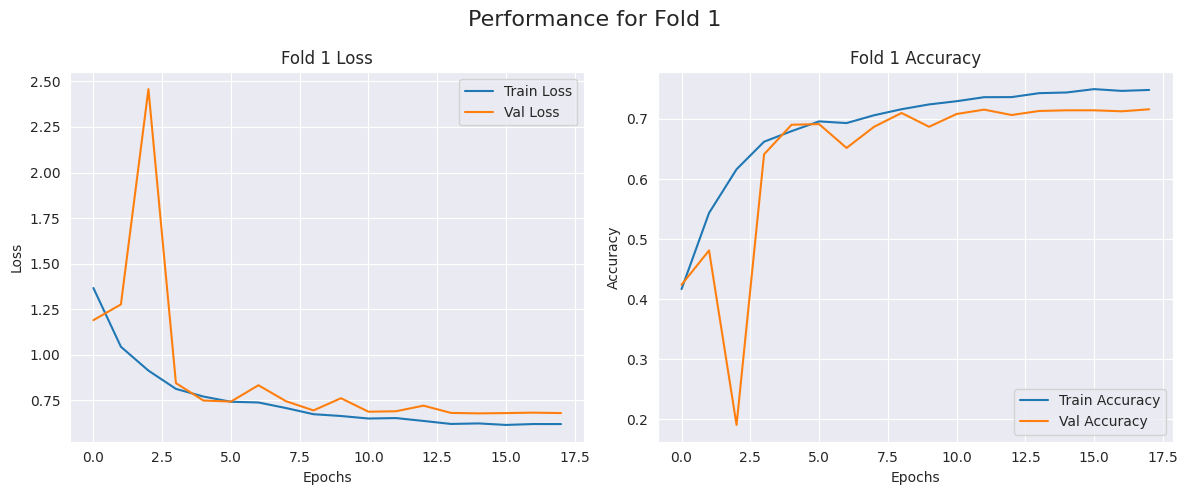

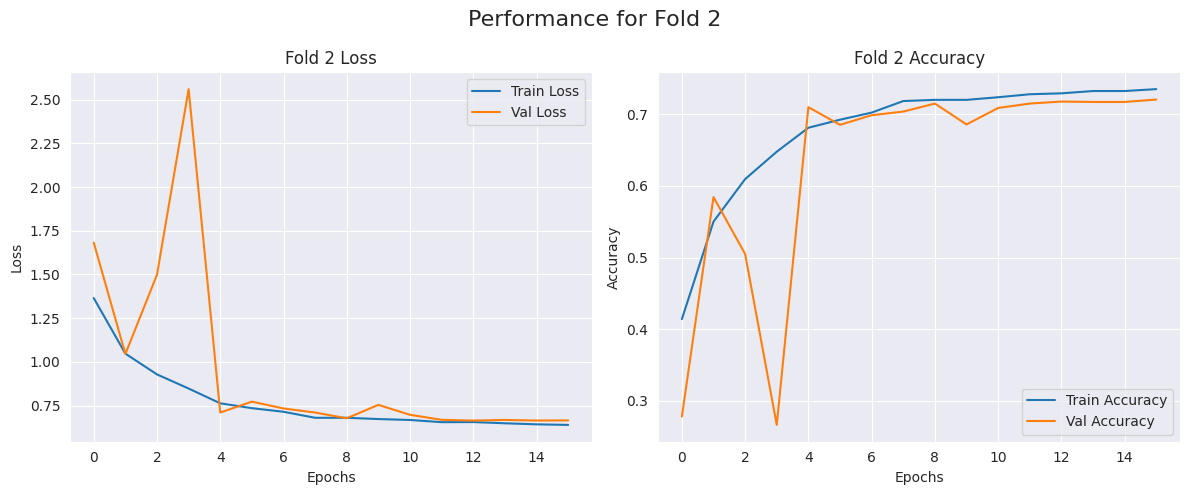

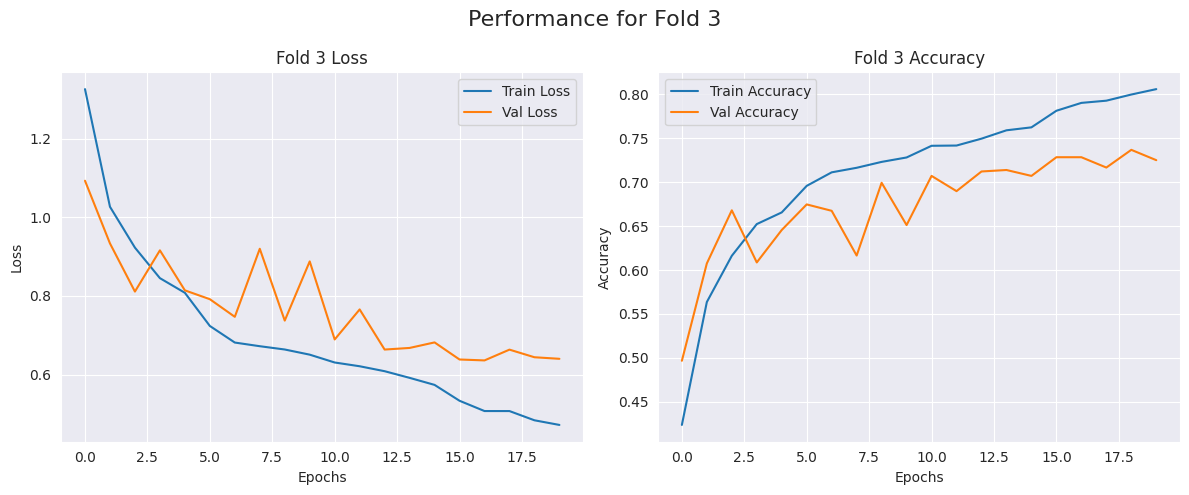

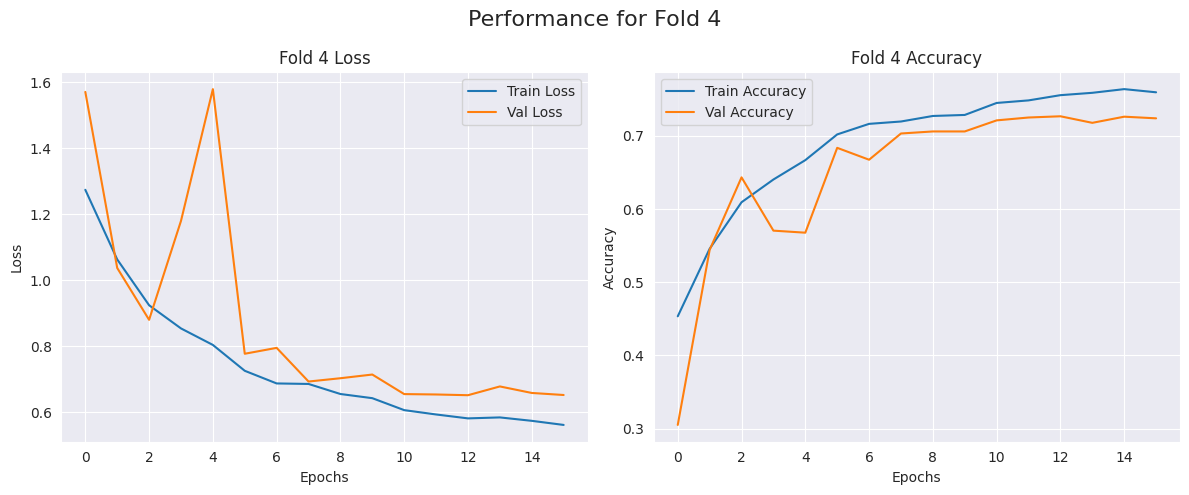

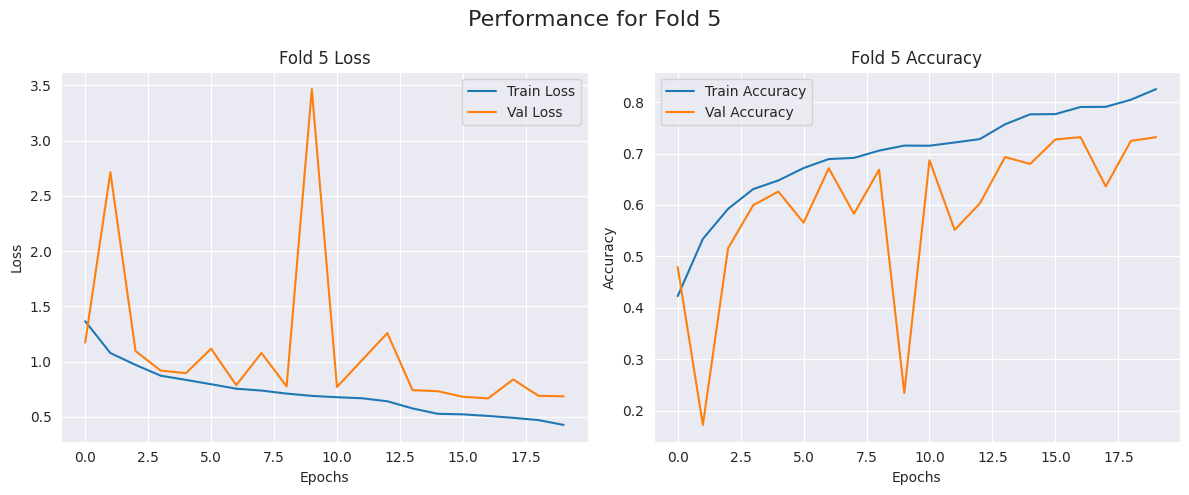

Semua plot selesai!


In [ ]:
for i, history in enumerate(histories, start=1):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Performance for Fold {i}', fontsize=16)
    plt.tight_layout()
    plt.show()  # tampilkan plot fold i

print("Semua plot selesai!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

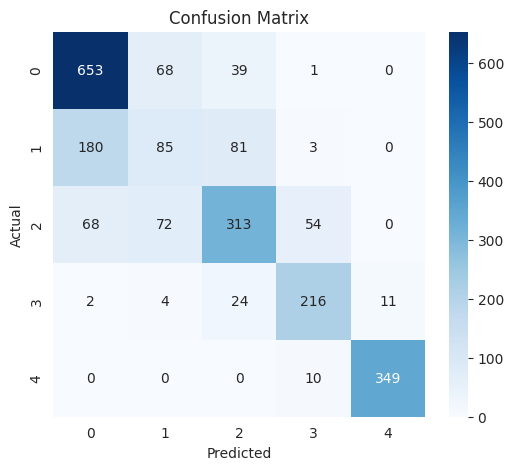

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       761
           1       0.37      0.24      0.29       349
           2       0.68      0.62      0.65       507
           3       0.76      0.84      0.80       257
           4       0.97      0.97      0.97       359

    accuracy                           0.72      2233
   macro avg       0.70      0.71      0.70      2233
weighted avg       0.70      0.72      0.71      2233



In [ ]:
y_true = []
y_pred = []
class_labels = list(test_gen.class_indices.keys())

for _ in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)
    y_true.extend(np.argmax(y_batch, axis=1))  # Label asli
    y_pred.extend(np.argmax(model.predict(x_batch), axis=1))  # Prediksi model

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
model.save('/content/drive/MyDrive/my_model_80_20_32.h5')